In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
from matplotlib import cm
from datetime import date

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
import math

In [2]:
%load_ext autoreload
%autoreload 2

Trying to ensure that my transformed field is correct.

From the 2020 CRD:
1) The field is about $B \approx 350 \mu$T in the strongest areas.
2) The spatial property of the field can be understood as a combination of the cyclotron stray field and local fields from the floor. At the height of z & 1.5m, the contribution from the cyclotron field is dominant, where each of the field components can be expressed as a smooth function of the position. The localities observed near the floor are likely due to magnetized steel reinforcement bars underneath the concrete floor.
3) At height z > 1.5m, the dominant field component is the z component $B_z \approx 240 \mu$T, pointing downward

In [3]:
# 1 gauss = 0.0001 tesla
def GtoT(G):
    return G*0.0001

In [4]:
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"
BField_Names = np.genfromtxt(file, delimiter=',', names=True).dtype.names
print(BField_Names)

file = './data_export/map_referencedPENTrack_interp50_cutCorners.txt'
df_BField = pd.read_csv(file, comment='#', sep="\t", names=BField_Names[1:])
df_BField.index.name = 'index'

('index', 'x', 'y', 'z', 'B_x', 'B_y', 'B_z')


In [5]:
## for comparison to the output of the old data interpolation with only the first step
##of the transform (not for PENTrack)
file2 = './data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv'
df_BField_old = pd.read_csv(file2)
df_BField_old = df_BField_old.drop('index', axis=1)
df_BField_old.index.name = 'index'
# df_BField

B_mag = np.sqrt(df_BField_old['B_x']**2 + df_BField_old['B_y']**2 + df_BField_old['B_z']**2)
df_BField_old['B'] = B_mag

In [6]:
print(BField_Names)
print("Min/Max of each spacial direction")
for i, dim in enumerate(BField_Names[1:4]):
    ma = np.max(df_BField[dim])
    mi = np.min(df_BField[dim])
    print(f" {dim}: [{mi}, {ma}] cm, total length: {ma - mi} cm")
    
#Remeber this is with the enfored rectlinear shape with 0 padding, so this 
#area should be larger than expected
    

('index', 'x', 'y', 'z', 'B_x', 'B_y', 'B_z')
Min/Max of each spacial direction
 x: [258.6103611874321, 815.6545526612382] cm, total length: 557.0441914738061 cm
 y: [-407.76603204233106, -4.389328524365212] cm, total length: 403.37670351796584 cm
 z: [-217.98, 130.52000000000004] cm, total length: 348.5 cm


In [7]:
#for point 1)
B_mag = np.sqrt(df_BField['B_x']**2 + df_BField['B_y']**2 + df_BField['B_z']**2)
df_BField['B'] = B_mag

print(f"The max magnitude of the B field: {max(B_mag)} G, or {GtoT(max(B_mag))*1e6} muT")

The max magnitude of the B field: 4.03734742313226 G, or 403.7347423132261 muT


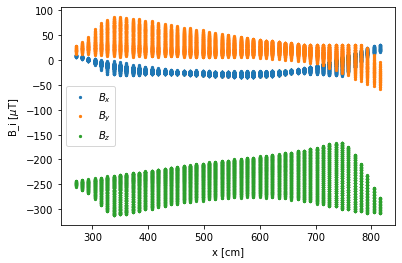

In [8]:
#for point 3)

#removing the weird edges of the rectangle that I needed to add for pentrack
df_BField_cutR = df_BField.loc[(df_BField['B_x']!=0)]

#this is 1.5 m from the floor in the PENTrack frame
topArea = 1.5 + (-1.25 + 188.1 -275)/100 + (16.3)/100 #m

#this is 1.5 m from the floor in the MSR frame
# topArea = 1.5 + (-1.25 + 188.1 -275)/100 #m


df_aboveZ15 = df_BField_cutR[ df_BField_cutR['z'] > topArea*100]

plt.scatter(df_aboveZ15['x'], GtoT(df_aboveZ15['B_x'])*1e6, s=5, label="$B_x$")
plt.scatter(df_aboveZ15['x'], GtoT(df_aboveZ15['B_y'])*1e6, s=5, label="$B_y$")
plt.scatter(df_aboveZ15['x'], GtoT(df_aboveZ15['B_z'])*1e6, s=5, label="$B_z$")
plt.xlabel("x [cm]")
plt.ylabel("B_i [$\mu$T]")
plt.legend()
plt.show()
#the Z component above ~z=1.5 m from the floor is indeed the strongest, and points downwards

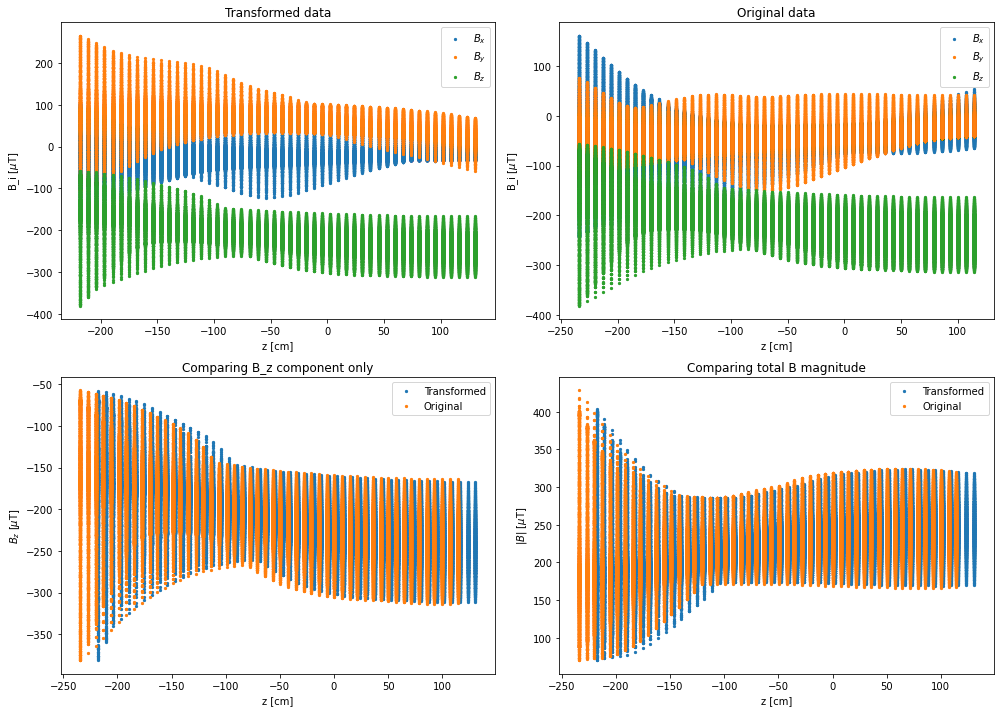

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

axs[0].scatter(df_BField_cutR['z'], GtoT(df_BField_cutR['B_x'])*1e6, s=5, label="$B_x$")
axs[0].scatter(df_BField_cutR['z'], GtoT(df_BField_cutR['B_y'])*1e6, s=5, label="$B_y$")
axs[0].scatter(df_BField_cutR['z'], GtoT(df_BField_cutR['B_z'])*1e6, s=5, label="$B_z$")
axs[0].set_xlabel("z [cm]")
axs[0].set_ylabel("B_i [$\mu$T]")
axs[0].set_title("Transformed data")
axs[0].legend(loc='upper right')

axs[1].scatter(df_BField_old['z'], GtoT(df_BField_old['B_x'])*1e6, s=5, label="$B_x$")
axs[1].scatter(df_BField_old['z'], GtoT(df_BField_old['B_y'])*1e6, s=5, label="$B_y$")
axs[1].scatter(df_BField_old['z'], GtoT(df_BField_old['B_z'])*1e6, s=5, label="$B_z$")
axs[1].set_xlabel("z [cm]")
axs[1].set_ylabel("B_i [$\mu$T]")
axs[1].set_title("Original data")
axs[1].legend(loc='upper right')

axs[2].scatter(df_BField_cutR['z'], GtoT(df_BField_cutR['B_z'])*1e6, s=5, label="Transformed")
axs[2].scatter(df_BField_old['z'], GtoT(df_BField_old['B_z'])*1e6, s=5, label="Original")
axs[2].set_xlabel("z [cm]")
axs[2].set_ylabel("$B_z$ [$\mu$T]")
axs[2].legend(loc='upper right')
axs[2].set_title("Comparing B_z component only")

axs[3].scatter(df_BField_cutR['z'], GtoT(df_BField_cutR['B'])*1e6, s=5, label="Transformed")
axs[3].scatter(df_BField_old['z'], GtoT(df_BField_old['B'])*1e6, s=5, label="Original")

axs[3].set_xlabel("z [cm]")
axs[3].set_ylabel("$|B|$ [$\mu$T]")
axs[3].legend(loc='upper right')
axs[3].set_title("Comparing total B magnitude")
plt.tight_layout()

plt.show()

Comparing parts as a function of z only, as there is no rotation on this axis, and only a quite small translation between Takashi's processed data (here labeled as original) and my transformed data.  
We see the B_z and |B| agree pretty well - with the z shift of 16.3 cm included they agree exactly (just add 16.3 cm to ```df_BField_old['z']```)